## This notebooks show that we can reduce RMSE and MAE by 
- Limiting the departure delay from -15 to 179, and
- Assigning one category for early departure less than -15, and
- Assigning one category for departure delays larger than 179

## Importing the need packages

In [1]:
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_squared_error, make_scorer
import matplotlib.pyplot as plt
import xgboost as xgb
import pandas as pd
import numpy as np
import os

In [2]:
# Set option to display all columns
pd.set_option('display.max_columns', None)

## Defining features and target(s)

In [3]:
features = [
    "QUARTER",
    "MONTH",
    "DAY_OF_MONTH",
    "DAY_OF_WEEK",

    "OP_CARRIER_AIRLINE_ID",
    "TAIL_NUM",
    "OP_CARRIER_FL_NUM",

    "ORIGIN_AIRPORT_ID",
    "ORIGIN_CITY_MARKET_ID",
    "ORIGIN_STATE_FIPS",
    "ORIGIN_WAC", #x
    "DEST_AIRPORT_ID",
    "DEST_CITY_MARKET_ID",
    "DEST_STATE_FIPS",
    "DEST_WAC", #x
    
    "CRS_DEP_TIME",
    "DEP_TIME_BLK", #x
    "CRS_ARR_TIME", 
    "ARR_TIME_BLK",
    "CRS_ELAPSED_TIME",
    "DISTANCE",
    "DISTANCE_GROUP", #x
]

target = "DEP_DELAY"

## Importing the training datasets

In [4]:
# Get the current script's directory
current_script_dir = os.getcwd()

# Move up to the parent directory
parent_dir = os.path.dirname(current_script_dir)

# Define the sibling data directory name
data_dir = os.path.join(parent_dir, 'data')

# Load the 2022 training datset
# Use os.path.join to create the full file path
training_dataset_filename = "encoded_training_dataset_2022.csv"
file_path = os.path.join(data_dir, training_dataset_filename)

# Read the CSV file into a DataFrame
dataset_df = pd.read_csv(file_path)
training_df = dataset_df[features+ [target]].copy()

# Display the DataFrame
display(training_df)

,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER_AIRLINE_ID,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_CITY_MARKET_ID,ORIGIN_STATE_FIPS,ORIGIN_WAC,DEST_AIRPORT_ID,DEST_CITY_MARKET_ID,DEST_STATE_FIPS,DEST_WAC,CRS_DEP_TIME,DEP_TIME_BLK,CRS_ARR_TIME,ARR_TIME_BLK,CRS_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,DEP_DELAY
0,1,1,1,6,20363,360,4732,10135,30135,42,23,11433,31295,26,43,1015,5,1209,7,114,425,2,-1
1,1,1,1,6,20363,360,5430,11433,31295,26,43,10135,30135,42,23,1422,9,1548,10,86,425,2,-3
2,1,1,1,6,20363,414,4671,10397,30397,13,34,14783,34783,29,64,2057,15,2149,16,112,563,3,-5
3,1,1,1,6,20363,414,5009,13487,31650,27,63,11423,31423,19,61,1041,5,1153,6,72,232,1,-3
4,1,1,1,6,20363,414,5083,11423,31423,19,61,10397,30397,13,34,1300,8,1610,11,130,743,3,-3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6551768,4,12,31,6,20452,5292,5741,12953,31703,36,22,11066,31066,39,44,830,3,1038,5,128,479,2,-7
6551769,4,12,31,6,20452,6245,3607,14321,34321,23,12,13930,30977,17,41,635,1,758,2,143,900,4,-7
6551770,4,12,31,6,20452,6245,3686,13930,30977,17,41,14321,34321,23,12,1800,13,2129,16,149,900,4,-7
6551771,4,12,31,6,20452,6245,3699,11003,31003,19,61,13930,30977,17,41,1508,10,1627,11,79,196,1,-10


## Making sure categorical types is marked as category in dataframe

In [5]:
training_df.dtypes

QUARTER                  int64
MONTH                    int64
DAY_OF_MONTH             int64
DAY_OF_WEEK              int64
OP_CARRIER_AIRLINE_ID    int64
TAIL_NUM                 int64
OP_CARRIER_FL_NUM        int64
ORIGIN_AIRPORT_ID        int64
ORIGIN_CITY_MARKET_ID    int64
ORIGIN_STATE_FIPS        int64
ORIGIN_WAC               int64
DEST_AIRPORT_ID          int64
DEST_CITY_MARKET_ID      int64
DEST_STATE_FIPS          int64
DEST_WAC                 int64
CRS_DEP_TIME             int64
DEP_TIME_BLK             int64
CRS_ARR_TIME             int64
ARR_TIME_BLK             int64
CRS_ELAPSED_TIME         int64
DISTANCE                 int64
DISTANCE_GROUP           int64
DEP_DELAY                int64
dtype: object

In [6]:
categorical_columns = [
    "OP_CARRIER_AIRLINE_ID",
    "TAIL_NUM",
    "OP_CARRIER_FL_NUM",

    "ORIGIN_AIRPORT_ID",
    "ORIGIN_CITY_MARKET_ID",
    "ORIGIN_STATE_FIPS",
    "ORIGIN_WAC",
    "DEST_AIRPORT_ID",
    "DEST_CITY_MARKET_ID",
    "DEST_STATE_FIPS",
    "DEST_WAC",
]

for column in categorical_columns:
    training_df[column] = training_df[column].astype('category')

In [7]:
training_df.dtypes

QUARTER                     int64
MONTH                       int64
DAY_OF_MONTH                int64
DAY_OF_WEEK                 int64
OP_CARRIER_AIRLINE_ID    category
TAIL_NUM                 category
OP_CARRIER_FL_NUM        category
ORIGIN_AIRPORT_ID        category
ORIGIN_CITY_MARKET_ID    category
ORIGIN_STATE_FIPS        category
ORIGIN_WAC               category
DEST_AIRPORT_ID          category
DEST_CITY_MARKET_ID      category
DEST_STATE_FIPS          category
DEST_WAC                 category
CRS_DEP_TIME                int64
DEP_TIME_BLK                int64
CRS_ARR_TIME                int64
ARR_TIME_BLK                int64
CRS_ELAPSED_TIME            int64
DISTANCE                    int64
DISTANCE_GROUP              int64
DEP_DELAY                   int64
dtype: object

## Defining functions for model evaluation

In [8]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [9]:
def evaluate_model(data_df, features_columns, target_column):
    features = data_df[features_columns]
    target = data_df[target_column]
    X_array = features.values
    y_array = target.values
    
    rmse_scores = []
    mae_scores = []
    
    kf = KFold(n_splits=2, shuffle=True, random_state=123)
    
    for train_index, test_index in kf.split(X_array):
        model = xgb.XGBRegressor(
            enable_categorical=True,
            objective='reg:squarederror', 
            eval_metric='rmse',
            random_state=123
        )
        
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]
        
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        
        rmse_scores.append(rmse(y_test, y_pred))
        mae_scores.append(mean_absolute_error(y_test, y_pred))
        
    return np.mean(rmse_scores), np.mean(mae_scores)

## Training and Evaluation using 2-fold Cross Validation

In [10]:
rmse_score, mae_score = evaluate_model(
    data_df=training_df, 
    features_columns=features, 
    target_column=target
)

print(f"Evaluation: Root Mean Squared Error: {rmse_score}")
print(f"Evaluation: Mean Absolute Error: {mae_score}")

Evaluation: Root Mean Squared Error: 53.09756956616911
Evaluation: Mean Absolute Error: 21.828851543795096


## Build a regressor using the 2022 dataset, and test it on the dataset from 2023

In [11]:
# Load the 2023 testing datset
# Use os.path.join to create the full file path
testing_dataset_filename = "encoded_evaluation_dataset_2023.csv"
testing_file_path = os.path.join(data_dir, testing_dataset_filename)

# Read the CSV file into a DataFrame
testing_dataset_df = pd.read_csv(testing_file_path)
testing_df = testing_dataset_df[features+[target]].copy()

# Display the DataFrame
display(testing_df)

,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER_AIRLINE_ID,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_CITY_MARKET_ID,ORIGIN_STATE_FIPS,ORIGIN_WAC,DEST_AIRPORT_ID,DEST_CITY_MARKET_ID,DEST_STATE_FIPS,DEST_WAC,CRS_DEP_TIME,DEP_TIME_BLK,CRS_ARR_TIME,ARR_TIME_BLK,CRS_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,DEP_DELAY
0,1,1,1,7,20363,319,5244,13930,30977,17,41,12478,31703,36,22,1520,10,1841,13,141,740,3,4
1,1,1,1,7,20363,319,5317,12478,31703,36,22,13930,30977,17,41,945,4,1144,6,179,740,3,-4
2,1,1,1,7,20363,319,5397,12478,31703,36,22,10581,30581,23,12,2100,16,2236,17,96,382,2,-4
3,1,1,1,7,20363,332,5076,10397,30397,13,34,14783,34783,29,64,1130,6,1225,7,115,563,3,-5
4,1,1,1,7,20363,332,5076,14783,34783,29,64,10397,30397,13,34,1400,9,1637,11,97,563,3,-6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6763361,4,12,31,7,20452,5247,5680,10721,30721,25,13,11066,31066,39,44,1315,8,1538,10,143,640,3,-5
6763362,4,12,31,7,20452,5247,5701,14122,30198,42,23,10721,30721,25,13,1038,5,1222,7,104,496,2,-7
6763363,4,12,31,7,20452,6245,3428,10431,30431,37,36,13930,30977,17,41,1515,10,1627,11,132,536,3,-7
6763364,4,12,31,7,20452,6245,3517,11193,33105,21,52,13930,30977,17,41,900,4,946,4,106,264,2,-7


## Making sure categorical types is marked as category in dataframe

In [12]:
testing_df.dtypes

QUARTER                  int64
MONTH                    int64
DAY_OF_MONTH             int64
DAY_OF_WEEK              int64
OP_CARRIER_AIRLINE_ID    int64
TAIL_NUM                 int64
OP_CARRIER_FL_NUM        int64
ORIGIN_AIRPORT_ID        int64
ORIGIN_CITY_MARKET_ID    int64
ORIGIN_STATE_FIPS        int64
ORIGIN_WAC               int64
DEST_AIRPORT_ID          int64
DEST_CITY_MARKET_ID      int64
DEST_STATE_FIPS          int64
DEST_WAC                 int64
CRS_DEP_TIME             int64
DEP_TIME_BLK             int64
CRS_ARR_TIME             int64
ARR_TIME_BLK             int64
CRS_ELAPSED_TIME         int64
DISTANCE                 int64
DISTANCE_GROUP           int64
DEP_DELAY                int64
dtype: object

In [13]:
categorical_columns = [
    "OP_CARRIER_AIRLINE_ID",
    "TAIL_NUM",
    "OP_CARRIER_FL_NUM",

    "ORIGIN_AIRPORT_ID",
    "ORIGIN_CITY_MARKET_ID",
    "ORIGIN_STATE_FIPS",
    "ORIGIN_WAC",
    "DEST_AIRPORT_ID",
    "DEST_CITY_MARKET_ID",
    "DEST_STATE_FIPS",
    "DEST_WAC",
]

for column in categorical_columns:
    testing_df[column] = testing_df[column].astype('category')

In [14]:
testing_df.dtypes

QUARTER                     int64
MONTH                       int64
DAY_OF_MONTH                int64
DAY_OF_WEEK                 int64
OP_CARRIER_AIRLINE_ID    category
TAIL_NUM                 category
OP_CARRIER_FL_NUM        category
ORIGIN_AIRPORT_ID        category
ORIGIN_CITY_MARKET_ID    category
ORIGIN_STATE_FIPS        category
ORIGIN_WAC               category
DEST_AIRPORT_ID          category
DEST_CITY_MARKET_ID      category
DEST_STATE_FIPS          category
DEST_WAC                 category
CRS_DEP_TIME                int64
DEP_TIME_BLK                int64
CRS_ARR_TIME                int64
ARR_TIME_BLK                int64
CRS_ELAPSED_TIME            int64
DISTANCE                    int64
DISTANCE_GROUP              int64
DEP_DELAY                   int64
dtype: object

In [15]:
# Train XGBoost model
model = xgb.XGBRegressor(
    enable_categorical=True,
    objective='reg:squarederror', 
    eval_metric='rmse',
    random_state=123
)

model.fit(training_df[features].values, training_df[target].values)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=123, ...)

In [16]:
y_test_true = testing_df[target].values
y_test_pred = model.predict(testing_df[features])

rmse_test_score = rmse(y_test_true, y_test_pred)
mae_test_score = mean_absolute_error(y_test_true, y_test_pred)

print(f"Training on 2022, Testing on 2023: Root Mean Squared Error: {rmse_test_score}")
print(f"Training on 2022, Testing on 2023: Mean Absolute Error: {mae_test_score}")

Training on 2022, Testing on 2023: Root Mean Squared Error: 57.38457331061827
Training on 2022, Testing on 2023: Mean Absolute Error: 27.108706245716174


## View most important features and choose most optimal combination of features

In [17]:
# Train XGBoost model
model = xgb.XGBRegressor(
    enable_categorical=True,
    objective='reg:squarederror', 
    eval_metric='rmse',
    random_state=123
)

model.fit(training_df[features], training_df[target])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=123, ...)

In [18]:
# Get feature importance
importance = model.get_booster().get_score(importance_type='gain')  # 'weight' or 'gain' or 'cover'

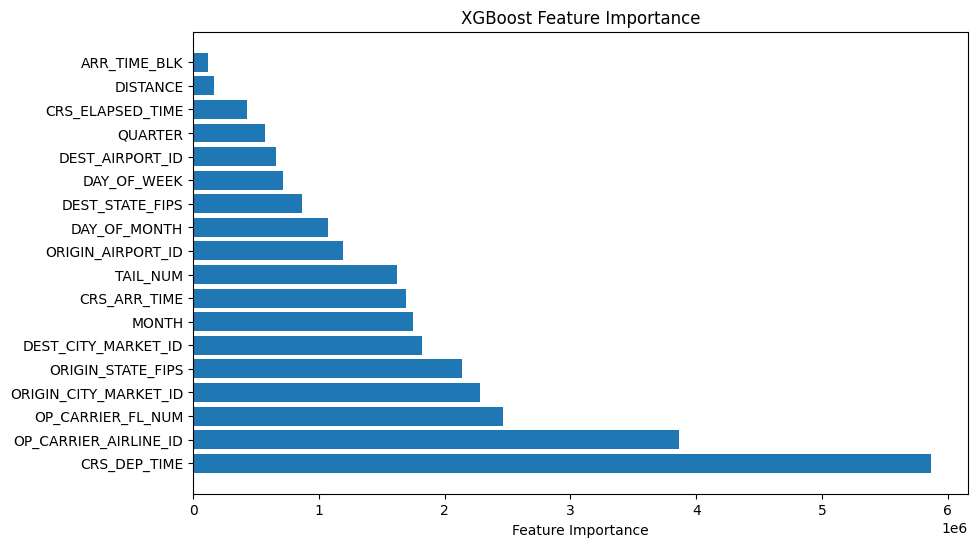

In [19]:
# Sort features by importance
sorted_features = sorted(importance.items(), key=lambda x: x[1], reverse=True)
important_features, importance_values = zip(*sorted_features)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(important_features, importance_values)
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importance')
plt.show()

## Note
- The features ORIGIN_WAC, DEST_WAC, DEP_TIME_BLK and DISTANCE_GROUP does not appear among the most important features, thus these features are considered non-informative or bias for this model.

## Try out a 18 models with n top important features where n goes from 1 to 18 features.
- So first model will use the feature CRS_DEP_TIME only
- Second model will use the features CRS_DEP_TIME and OP_CARRIER_AIRLINE_ID
- and so on. until last model uses all of the 18 most important features.

## Look for the top important combination that give the best RMSE and/or MAE among all models.

In [20]:
rmse_scores, mae_scores = [], []

important_features = list(important_features)
for n in range(1, len(important_features)+1):
    print(f"Adding {important_features[n-1]} and trying model number {n}...")
    n_top_features = important_features[0:n]

    rmse_score, mae_score = evaluate_model(
        data_df=training_df, 
        features_columns=n_top_features, 
        target_column=target
    )
    
    rmse_scores.append(rmse_score)
    mae_scores.append(mae_score)

print("done.")

Adding CRS_DEP_TIME and trying model number 1...
Adding OP_CARRIER_AIRLINE_ID and trying model number 2...
Adding OP_CARRIER_FL_NUM and trying model number 3...
Adding ORIGIN_CITY_MARKET_ID and trying model number 4...
Adding ORIGIN_STATE_FIPS and trying model number 5...
Adding DEST_CITY_MARKET_ID and trying model number 6...
Adding MONTH and trying model number 7...
Adding CRS_ARR_TIME and trying model number 8...
Adding TAIL_NUM and trying model number 9...
Adding ORIGIN_AIRPORT_ID and trying model number 10...
Adding DAY_OF_MONTH and trying model number 11...
Adding DEST_STATE_FIPS and trying model number 12...
Adding DAY_OF_WEEK and trying model number 13...
Adding DEST_AIRPORT_ID and trying model number 14...
Adding QUARTER and trying model number 15...
Adding CRS_ELAPSED_TIME and trying model number 16...
Adding DISTANCE and trying model number 17...
Adding ARR_TIME_BLK and trying model number 18...
done.


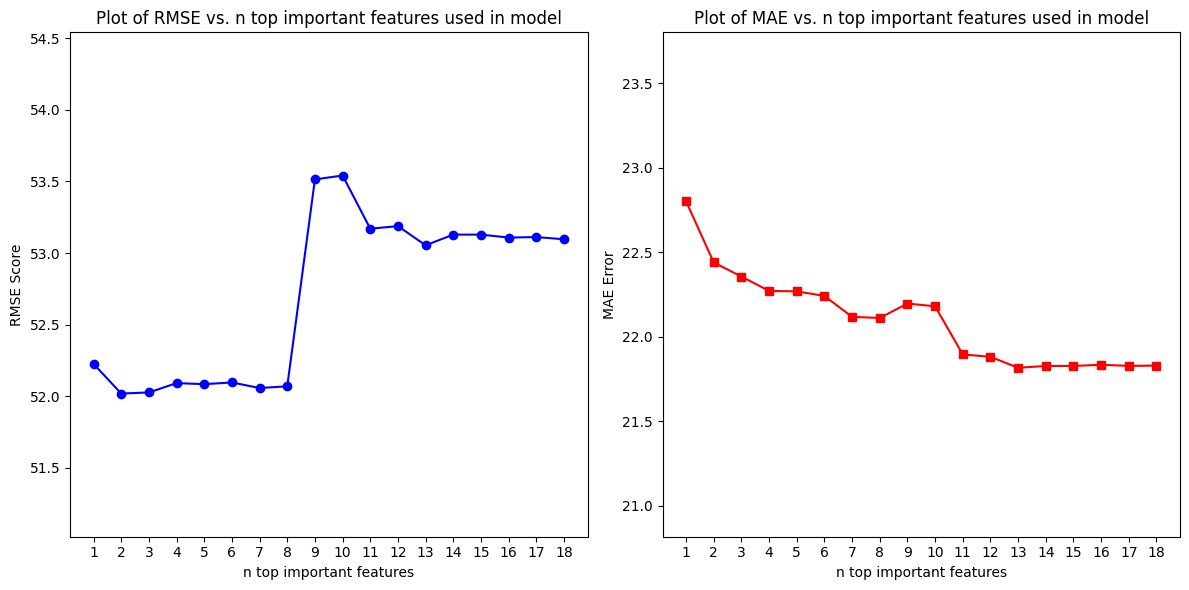

In [21]:
X = list(range(1, len(important_features)+1, 1))

# Create a 1x2 subplot
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot rmse_scores on the left subplot
axs[0].plot(X, rmse_scores, marker='o', color='blue')
axs[0].set_title('Plot of RMSE vs. n top important features used in model')
axs[0].set_xlabel('n top important features')
axs[0].set_ylabel('RMSE Score')
axs[0].set_xticks(X)
axs[0].set_ylim(min(rmse_scores)-1, max(rmse_scores)+1)  # Adjust y-axis based on rmse_scores

# Plot mae_scores on the right subplot
axs[1].plot(X, mae_scores, marker='s', color='red')
axs[1].set_title('Plot of MAE vs. n top important features used in model')
axs[1].set_xlabel('n top important features')
axs[1].set_ylabel('MAE Error')
axs[1].set_xticks(X)
axs[1].set_ylim(min(mae_scores)-1, max(mae_scores)+1)  # Adjust y-axis based on mae_scores

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

## Seems like taking the top 8 most important features offers a better trade off between RMSE and MAE
- Repeat building a model using top 8 most important features, training it on data from 2022 and testing on data from 2023

In [22]:
# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(training_df[important_features[0:7]].values, training_df[target].values, test_size=0.5, random_state=123)

model = xgb.XGBRegressor(
    n_estimators=10000,
    enable_categorical=True,
    objective='reg:squarederror', 
    eval_metric='rmse',
    early_stopping_rounds=50,  # Stop if no improvement after 50 rounds
    random_state=123
)

# Fit the model with early stopping (monitoring the validation error)
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],  # Validation set to monitor performance
    verbose=False  # True to print training progress
)

# Print the best iteration (i.e., number of trees) based on early stopping
print(f"Best number of trees: {model.best_iteration}")

Best number of trees: 227


In [24]:
model = xgb.XGBRegressor(
    n_estimators=227,
    enable_categorical=True,
    objective='reg:squarederror', 
    random_state=123
)

model.fit(training_df[important_features[0:7]].values, training_df[target].values)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=227, n_jobs=None,
             num_parallel_tree=None, random_state=123, ...)

In [26]:
y_test_true = testing_df[target].values
y_test_pred = model.predict(testing_df[important_features[0:7]].values)

rmse_test_score = rmse(y_test_true, y_test_pred)
mae_test_score = mean_absolute_error(y_test_true, y_test_pred)

print(f"Training on 2022, Testing on 2023: Root Mean Squared Error: {rmse_test_score}")
print(f"Training on 2022, Testing on 2023: Mean Absolute Error: {mae_test_score}")

Training on 2022, Testing on 2023: Root Mean Squared Error: 54.830946350917614
Training on 2022, Testing on 2023: Mean Absolute Error: 22.854766852089778


## View Error statstics to see range of error and try to identify what predictions is driving the RMSE up

In [48]:
testing_error_df = pd.DataFrame({'2023_y_true': y_test_true, '2023_y_pred': y_test_pred})
testing_error_df['Error'] = round(abs(testing_error_df['2023_y_true'] - testing_error_df['2023_y_pred']))
pd.set_option('display.float_format', '{:.6f}'.format)
display(testing_error_df.describe())

,2023_y_true,2023_y_pred,Error
count,6763366.000000,6763366.000000,6763366.000000
mean,12.285409,12.927512,22.854408
std,55.328527,10.257023,49.841743
min,-99.000000,-28.000000,0.000000
25%,-5.000000,6.000000,8.000000
50%,-2.000000,11.000000,14.000000
75%,9.000000,18.000000,22.000000
max,4413.000000,612.000000,4411.000000


In [50]:
# Calculate percentiles (from 10% to 100% with 10% steps)
percentiles = range(10, 101, 5)
percentile_values = [testing_error_df['Error'].quantile(p / 100) for p in percentiles]

# Display the results
percentile_dict = {f'{p}th percentile': value for p, value in zip(percentiles, percentile_values)}

for p, value in percentile_dict.items():
    print(f'{p}: {value}')

10th percentile: 4.0
15th percentile: 6.0
20th percentile: 7.0
25th percentile: 8.0
30th percentile: 9.0
35th percentile: 10.0
40th percentile: 12.0
45th percentile: 13.0
50th percentile: 14.0
55th percentile: 15.0
60th percentile: 17.0
65th percentile: 18.0
70th percentile: 20.0
75th percentile: 22.0
80th percentile: 25.0
85th percentile: 30.0
90th percentile: 37.0
95th percentile: 63.0
100th percentile: 4411.0


## Try setting early departure as 0 minute delay and see if that help in predicting departure delay in a more accurate way

In [42]:
# Create a new delay column DEP_DELAY_NEW where early departure is set to 0
training_df['DEP_DELAY_NEW'] = training_df['DEP_DELAY'].apply(lambda x: 0 if x < 0 else x)

rmse_score, mae_score = evaluate_model(
    data_df=training_df, 
    features_columns=features, 
    target_column='DEP_DELAY_NEW'
)

print(f"Evaluation: Root Mean Squared Error: {rmse_score}")
print(f"Evaluation: Mean Absolute Error: {mae_score}")

Evaluation: Root Mean Squared Error: 52.26524813970198
Evaluation: Mean Absolute Error: 20.605302499796707


## Calculate the 90% percentile of DEP_DELAY, then remove all rows with DEP_DELAY values higher than 90%
- Train and evaluate a model with the remaining data

In [55]:
# Calculate the 90th percentile value of column 'DEP_DELAY'
percentile_90 = training_df['DEP_DELAY'].quantile(0.9)

# Filter the DataFrame to keep only rows where 'DEP_DELAY' is less than or equal to the 90th percentile
training_df_filtered = training_df[training_df['DEP_DELAY'] <= percentile_90]

# Display the filtered DataFrame
print("\nFiltered DataFrame (removing rows where A > 90th percentile):")
display(training_df_filtered)


Filtered DataFrame (removing rows where A > 90th percentile):


,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER_AIRLINE_ID,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_CITY_MARKET_ID,ORIGIN_STATE_FIPS,ORIGIN_WAC,DEST_AIRPORT_ID,DEST_CITY_MARKET_ID,DEST_STATE_FIPS,DEST_WAC,CRS_DEP_TIME,DEP_TIME_BLK,CRS_ARR_TIME,ARR_TIME_BLK,CRS_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,DEP_DELAY,DEP_DELAY_NEW
0,1,1,1,6,20363,360,4732,10135,30135,42,23,11433,31295,26,43,1015,5,1209,7,114,425,2,-1,0
1,1,1,1,6,20363,360,5430,11433,31295,26,43,10135,30135,42,23,1422,9,1548,10,86,425,2,-3,0
2,1,1,1,6,20363,414,4671,10397,30397,13,34,14783,34783,29,64,2057,15,2149,16,112,563,3,-5,0
3,1,1,1,6,20363,414,5009,13487,31650,27,63,11423,31423,19,61,1041,5,1153,6,72,232,1,-3,0
4,1,1,1,6,20363,414,5083,11423,31423,19,61,10397,30397,13,34,1300,8,1610,11,130,743,3,-3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6551768,4,12,31,6,20452,5292,5741,12953,31703,36,22,11066,31066,39,44,830,3,1038,5,128,479,2,-7,0
6551769,4,12,31,6,20452,6245,3607,14321,34321,23,12,13930,30977,17,41,635,1,758,2,143,900,4,-7,0
6551770,4,12,31,6,20452,6245,3686,13930,30977,17,41,14321,34321,23,12,1800,13,2129,16,149,900,4,-7,0
6551771,4,12,31,6,20452,6245,3699,11003,31003,19,61,13930,30977,17,41,1508,10,1627,11,79,196,1,-10,0


In [56]:
rmse_score, mae_score = evaluate_model(
    data_df=training_df_filtered, 
    features_columns=features, 
    target_column='DEP_DELAY'
)

print(f"Evaluation: Root Mean Squared Error: {rmse_score}")
print(f"Evaluation: Mean Absolute Error: {mae_score}")

Evaluation: Root Mean Squared Error: 10.442197008845062
Evaluation: Mean Absolute Error: 7.342811877465991


## Test on data from 2023
- Train model based on the model with removed outliers from 2022 dataset

In [57]:
model = xgb.XGBRegressor(
    n_estimators=227,
    enable_categorical=True,
    objective='reg:squarederror', 
    random_state=123
)

model.fit(training_df_filtered[features].values, training_df_filtered['DEP_DELAY'].values)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=227, n_jobs=None,
             num_parallel_tree=None, random_state=123, ...)

In [58]:
y_test_true = testing_df['DEP_DELAY'].values
y_test_pred = model.predict(testing_df[features].values)

rmse_test_score = rmse(y_test_true, y_test_pred)
mae_test_score = mean_absolute_error(y_test_true, y_test_pred)

print(f"Training on 2022, Testing on 2023: Root Mean Squared Error: {rmse_test_score}")
print(f"Training on 2022, Testing on 2023: Mean Absolute Error: {mae_test_score}")

Training on 2022, Testing on 2023: Root Mean Squared Error: 55.94811903392616
Training on 2022, Testing on 2023: Mean Absolute Error: 18.106121242387676


## RMSE still high

In [68]:
# Calculate the 90th percentile value of column 'DEP_DELAY'
percentile_90 = training_df['DEP_DELAY'].quantile(0.85)
#percentile_10 = training_df['DEP_DELAY'].quantile(0.15)

# Filter the DataFrame to keep only rows where 'DEP_DELAY' is less than or equal to the 90th percentile
training_df_filtered = training_df[(training_df['DEP_DELAY'] <= percentile_90) & (training_df['DEP_DELAY'] >= 0)]

# Display the filtered DataFrame
print("\nFiltered DataFrame (removing rows where A > 90th percentile):")
display(training_df_filtered)


Filtered DataFrame (removing rows where A > 90th percentile):


,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER_AIRLINE_ID,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_CITY_MARKET_ID,ORIGIN_STATE_FIPS,ORIGIN_WAC,DEST_AIRPORT_ID,DEST_CITY_MARKET_ID,DEST_STATE_FIPS,DEST_WAC,CRS_DEP_TIME,DEP_TIME_BLK,CRS_ARR_TIME,ARR_TIME_BLK,CRS_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,DEP_DELAY,DEP_DELAY_NEW
9,1,1,1,6,20363,477,4680,11193,33105,21,52,12953,31703,36,22,1100,6,1257,7,117,585,3,0,0
10,1,1,1,6,20363,477,5318,11433,31295,26,43,11193,33105,21,52,829,3,946,4,77,229,1,10,10
29,1,1,1,6,20363,626,5324,11953,31953,12,33,10397,30397,13,34,1630,11,1757,12,87,300,2,24,24
32,1,1,1,6,20363,664,5303,11193,33105,21,52,11433,31295,26,43,1020,5,1136,6,76,229,1,11,11
45,1,1,1,6,20363,1261,4813,11423,31423,19,61,13487,31650,27,63,1323,8,1440,9,77,232,1,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6551735,4,12,31,6,20452,4542,4688,14574,34574,51,38,12953,31703,36,22,1404,9,1539,10,95,405,2,1,1
6551737,4,12,31,6,20452,4571,5848,12953,31703,36,22,11278,30852,51,38,930,4,1106,6,96,214,1,22,22
6551741,4,12,31,6,20452,4880,3616,11624,31624,12,33,11618,31703,34,21,1225,7,1536,10,191,1196,5,22,22
6551742,4,12,31,6,20452,4897,3490,11624,31624,12,33,12264,30852,51,38,1329,8,1615,11,166,1023,5,0,0


In [69]:
rmse_score, mae_score = evaluate_model(
    data_df=training_df_filtered, 
    features_columns=features, 
    target_column='DEP_DELAY'
)

print(f"Evaluation: Root Mean Squared Error: {rmse_score}")
print(f"Evaluation: Mean Absolute Error: {mae_score}")

Evaluation: Root Mean Squared Error: 7.471777784064808
Evaluation: Mean Absolute Error: 6.195489291857193


In [70]:
model = xgb.XGBRegressor(
    n_estimators=227,
    enable_categorical=True,
    objective='reg:squarederror', 
    random_state=123
)

model.fit(training_df_filtered[features].values, training_df_filtered['DEP_DELAY'].values)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=227, n_jobs=None,
             num_parallel_tree=None, random_state=123, ...)

In [71]:
y_test_true = testing_df['DEP_DELAY'].values
y_test_pred = model.predict(testing_df[features].values)

rmse_test_score = rmse(y_test_true, y_test_pred)
mae_test_score = mean_absolute_error(y_test_true, y_test_pred)

print(f"Training on 2022, Testing on 2023: Root Mean Squared Error: {rmse_test_score}")
print(f"Training on 2022, Testing on 2023: Mean Absolute Error: {mae_test_score}")

Training on 2022, Testing on 2023: Root Mean Squared Error: 55.31481376356801
Training on 2022, Testing on 2023: Mean Absolute Error: 21.030220434628347
